In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
import base64
import io
# from scipy.misc import imread
import codecs
from IPython.display import HTML
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold

In [5]:
movies = pd.read_csv('../dataset/tmdb_5000_movies.csv')
credits = pd.read_csv('../dataset/tmdb_5000_credits.csv')

movies.head(3)
#credits.head(3)

# Possible features: keywords, popularity, production_countries,
# revenue, vote_count


# Clean the dataset by converting json columns into list of strings
fields = ['genres', 'keywords', 'production_companies', 'production_countries']
for field in fields:
    movies[field]=movies[field].apply(json.loads)
    for index,i in zip(movies.index,movies[field]):
        list1=[]
        for j in range(len(i)):
            list1.append((i[j]['name']))
        movies.loc[index,field]=str(list1)
        
        
# Clean the credits 
credits['cast']=credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1=[]
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'cast']=str(list1)

fields = ['crew']
for field in fields:
    credits[field] = credits[field].apply(json.loads)
    def director(x):
        for i in x:
            if i['job'] == 'Director':
                return i['name']
    credits['crew'] = credits['crew'].apply(director)
    credits.rename(columns={'crew':'director'},inplace=True)
    
# Need to combine two datasets. Can join on movie_id
df = pd.merge(movies, credits, how='left', left_on='id', right_on='movie_id')

# Feature engineering! select which ones we want here...
features = ['id', 'original_title', 'genres', 'cast', 'vote_average', 'director', 'keywords', 'popularity', 'vote_count']
df = df[features]

# Find top genres
df['genres'] = df['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('Adventure', 'Adv').str.replace('u', '').str.replace('Adv', 'Adventure')
df['genres'] = df['genres'].str.split(',')

# Create an ordered list of all possible genres so we can use a bit string to represent them
genreList = []
for genres in df['genres']:
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
            
genreList.sort()
genreList = genreList[1:]

# Create the bitstring of genres
def genre_bitlist(genres):
    blist = []
    for genre in genreList:
        if genre in genres:
            blist.append(1)
        else:
            blist.append(0)
    return blist

            
df['genres_bs'] = df['genres'].apply(lambda x: genre_bitlist(x))

# Work with cast. Let's get the top 25 actors
n = 25

df['cast']=df['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
df['cast']=df['cast'].str.split(',')

import operator 
actorList = []
list1 = []
for i in df['cast']:
    list1.extend(i)
    
actors = {}
for actor in list1:
    if actor in actors:
        actors[actor] += 1
    else:
        actors[actor] = 1
        
sorted_actors = sorted(actors.items(), key=operator.itemgetter(1))

for i in range(0, 21):
    actorList.append(sorted_actors[-1-i])
    

actorList = [actor[0] for actor in actorList]
alist = []
for actor in actorList:
    if actor != 'r.': # Get rid of this trailing value
        alist.append(actor)
actorList = alist

# Now we need to sort the list!
actorList = sorted(actorList)
actorList = actorList[1:]

# Create the bitstring of genres
def actor_bitlist(actors):
    blist = []
    for actor in actorList:
        if actor in actors:
            blist.append(1)
        else:
            blist.append(0)
    return blist

df['cast_bs'] = df['cast'].apply(lambda x: actor_bitlist(x))

# Now directors
def isnull(s):
    if s is None:
        return ''
    return s

df['director'] = df['director'].apply(isnull)

directorList = []
for director in df['director']:
    if director not in directorList:
        directorList.append(director)
        
directorList = sorted(directorList)[1:]

def director_bitlist(directors):
    blist = []
    for director in directorList:
        if director in directors:
            blist.append(1)
        else:
            blist.append(0)
    return blist

df['director_bs'] = df['director'].apply(lambda x: director_bitlist(x))

# Allows us to make each genre a category in the dataframe
from collections import defaultdict
cols = defaultdict(list)
for g in genreList:
    for index, row in df.iterrows():
        genres = row["genres"]
        if g in genres:
            cols[g].append(1)
        else:
            cols[g].append(0)
        
    df[g] = cols[g]

# Allows us to make each actor a category in the dataframe
from collections import defaultdict
cols = defaultdict(list)
for a in actorList:
    for index, row in df.iterrows():
        cast = row["cast"]
        if a in cast:
            cols[a].append(1)
        else:
            cols[a].append(0)
        
    df[a] = cols[a]
    
total_features = ['popularity',  'vote_count', 'Action', 'Adventure', 'Animation', 'Comedy', 'Docmentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Mystery', 'Romance', 'ScienceFiction', 'Thriller', 'War', 'Western', 'AlecBaldwin', 'BradPitt', 'BruceWillis', 'JohnGoodman', 'JohnnyDepp', 'LiamNeeson', 'MattDamon', 'MorganFreeman', 'NicolasCage', 'OwenWilson', 'RobertDeNiro', 'SamuelL.Jackson', 'SteveBuscemi', 'WillFerrell', 'WillemDafoe']
target = ['vote_average']

X = df[total_features]
Y = df[target]

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
data = imp.fit_transform(X)
labels = imp.fit_transform(Y)

data = np.log(data)
labels = np.log(labels)

data[data==-np.inf]=0
labels[labels==-np.inf]=0

In [6]:
X.head()

,popularity,vote_count,Action,Adventure,Animation,Comedy,Docmentary,Drama,Family,Fantasy,...,LiamNeeson,MattDamon,MorganFreeman,NicolasCage,OwenWilson,RobertDeNiro,SamuelL.Jackson,SteveBuscemi,WillFerrell,WillemDafoe
0,150.437577,11800,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,139.082615,4500,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,107.376788,4466,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,112.312950,9106,1,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
4,43.926995,2124,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [47]:
pca = PCA(whiten=True)
pca.fit(data)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

array([ 0.9620059,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ])

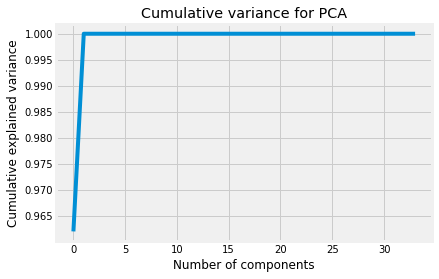

In [48]:
# plot the variances of each principal component
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative variance for PCA')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

explained variance ratio (first 2 components): [  9.99737051e-01   2.61738133e-04]


Text(0,0.5,'Principle Component 2')

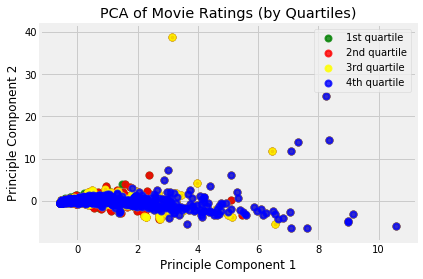

In [49]:
pca = PCA(whiten=True,n_components=2)
X_r = pca.fit(X).transform(X)

target_names = ["1st quartile","2nd quartile","3rd quartile","4th quartile"]
y = Y.values.flatten()

print('explained variance ratio (first 2 components): %s'
      % str(pca.explained_variance_ratio_))

fig = plt.figure()
colors = ['green', 'red', 'yellow', 'blue']
lw = 2

# ax = fig.add_subplot(111, projection='2d')
for color, i, target_name in zip(colors, [0, 25, 50, 75], target_names):
    plt.scatter(X_r[y > np.percentile(y,i), 0], X_r[y > np.percentile(y,i), 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Movie Ratings (by Quartiles)')
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")

In [50]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.model_selection import GridSearchCV

lin = linear_model.LinearRegression()

# since the first 2 principle components explain nearly 100% of the variance, we'll perform our PCA on just 2 components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X)
cv_results = cross_validate(lin, X, Y, cv=10, scoring='neg_mean_squared_error')
pca_cv_results = cross_validate(lin, pca_data, Y, cv=10, scoring='neg_mean_squared_error')

In [51]:
from functools import reduce

def get_cv_results(cv_results):
    test_score = cv_results['test_score']
    train_score = cv_results['train_score']
    fit_time = cv_results['fit_time']

    print("mean test score: ", reduce(lambda x, y: abs(x)+abs(y), test_score)/len(test_score))
    print("mean train score: ", reduce(lambda x, y: abs(x)+abs(y), train_score)/len(train_score))
    print("mean fit time: ", reduce(lambda x, y: abs(x)+abs(y), fit_time)/len(fit_time))

In [52]:
print("Linear Reg w/o PCA")
get_cv_results(cv_results)
print("\nLinear Reg w/ PCA")
get_cv_results(pca_cv_results)

Linear Reg w/o PCA
mean test score:  1.2391289483
mean train score:  1.12905262327
mean fit time:  0.0137400627136

Linear Reg w/ PCA
mean test score:  1.37127079673
mean train score:  1.28053905997
mean fit time:  0.00194430351257
